# Prep regridding input: open RiOMar/GAMAR via Kerchunk → write a temporary Zarr

This notebook prepares a **small, reproducible Zarr subset** that is fast to iterate on for regridding experiments.

It opens the dataset from a **Kerchunk catalog** generated on HPC, and the *same* workflow can open:
- directly on the HPC filesystem, or
- over HTTPS via the DATARMOR export service (`https://data-fair2adapt.ifremer.fr/`).

## Goal
Produce a temporary Zarr (e.g. `small.zarr`) that is then used as input to:
- `regrid_apply_ufunc.ipynb`

## Outputs
- `OUT_ZARR`: a lightweight subset written to Zarr (local or HPC scratch)

## Steps
1. **Open the dataset** from a Kerchunk catalog (portable: HPC filesystem or HTTPS export)
2. **Select variables** and ensure lon/lat are explicit coordinates
3. **Build a polygon mask** helper for the model grid
4. **Define the ROI** and apply the mask (load ROI polygon, mask, and subset)
5. **Write a temporary Zarr** (e.g. `small.zarr`) for use by `regrid_apply_ufunc.ipynb`


Tip: keep this subset small (few timesteps / ROI mask) until the workflow is validated.



## Kerchunk catalog options

A **Kerchunk catalog** is a JSON mapping that lets Xarray open a collection of NetCDF (or similar) files as a *virtual* Zarr dataset.  
Depending on where you run this notebook, you can point to:

- **HPC filesystem path** (fast, when you have direct access to `/scale/...`)
- **HTTPS export** (portable, when you access the same data through `https://data-fair2adapt.ifremer.fr/`)

Below are example catalog paths that have been created previously (kept here as a reference).


## 1. **Open the dataset** from a Kerchunk catalog (portable: HPC filesystem or HTTPS export)

Many Kerchunk catalogs store references to the original files (often as absolute HPC paths).  
When opening through HTTPS, we **rewrite** those references from:

`/scale/project/lops-oh-fair2adapt/...` → `https://data-fair2adapt.ifremer.fr/...`

The cell below:
1. Detects whether the HPC path exists (so we are running on the cluster).
2. Otherwise loads the JSON over HTTPS, patches references in-memory, and opens the dataset.
3. (Optional) can cache the patched references locally as a parquet file for faster re-opening.


In [2]:
%%time
# this takes 4 s
#
import json
import fsspec
from pathlib import Path

#import fsspec
import xarray as xr

HPC_PREFIX    = "/scale/project/lops-oh-fair2adapt/"
HTTPS_PREFIX  = "https://data-fair2adapt.ifremer.fr/"
CATALOG_PATH  = "fpaul/tmp/riomar_3months.json"
OUT_PARQUET   = "riomar_3months_.parq"   # local parquet refs cache

def patch_kc_refs_inplace(kc, hpc_prefix=HPC_PREFIX, https_prefix=HTTPS_PREFIX):
    refs = kc.get("refs", kc.get("references"))
    if refs is None:
        raise KeyError("Can't find 'refs' (or 'references') in kerchunk JSON")

    def patch_target(x):
        if isinstance(x, str) and x.startswith(hpc_prefix):
            return https_prefix + x[len(hpc_prefix):]
        return x

    for k, v in list(refs.items()):
        if isinstance(v, list) and v and isinstance(v[0], str):
            refs[k] = [patch_target(v[0])] + v[1:]
        elif isinstance(v, str):
            refs[k] = patch_target(v)

    kc["refs"] = refs
    return kc


# ------------------------------
# 1) HPC mode: open directly
# ------------------------------
if Path(HPC_PREFIX).exists():
    KERCHUNK_CATALOG = HPC_PREFIX + CATALOG_PATH
    print("Running in HPC mode:", KERCHUNK_CATALOG)

    ds = xr.open_dataset(KERCHUNK_CATALOG, engine="kerchunk", chunks={})

# ------------------------------
# 2) HTTPS mode: prefer local parquet cache if present
# ------------------------------
else:
    KERCHUNK_CATALOG = HTTPS_PREFIX + CATALOG_PATH
    print("Running in HTTPS mode:", KERCHUNK_CATALOG)
    # If parquet refs already exist locally, open them (fast path)
    # This part is commented since on the fly transformation is faster than loading the parquet file in actual config
    # (check why at some point) 
    # Loading from local parquet is also slower than loading json and convert the path on the fly...
    # thus i deactivate the if here
    #if Path(OUT_PARQUET).exists():
    if False and Path(OUT_PARQUET).exists():
        print(f"✅ Found local parquet refs: ./{OUT_PARQUET} -> opening that")
        xr.open_dataset(OUT_PARQUET, engine="kerchunk", chunks={})

    # Else: fetch JSON, patch refs to https, open, AND write parquet refs cache
    else:
        print(f"ℹ️ No local parquet refs found at ./{OUT_PARQUET} -> creating them from JSON")

        with fsspec.open(KERCHUNK_CATALOG, "rt") as f:
            kc = json.load(f)

        kc = patch_kc_refs_inplace(kc)

        # open now (from in-memory dict)
        ds = xr.open_dataset(kc, engine="kerchunk", chunks={})

        ## write parquet refs cache for next time
        #import kerchunk.df as kcdf
        #kcdf.refs_to_dataframe(kc, OUT_PARQUET)
        #print("✅ Wrote kerchunk parquet refs to:", OUT_PARQUET)

ds

Running in HTTPS mode: https://data-fair2adapt.ifremer.fr/fpaul/tmp/riomar_3months.json
ℹ️ No local parquet refs found at ./riomar_3months_.parq -> creating them from JSON
CPU times: user 1.41 s, sys: 320 ms, total: 1.73 s
Wall time: 27.6 s


<xarray.Dataset> Size: 866GB
Dimensions:              (time_counter: 2208, s_rho: 40, s_w: 41, y_rho: 838,
                          x_rho: 727, y_u: 838, x_u: 726, y_v: 837, x_v: 727,
                          axis_nbounds: 2)
Coordinates: (12/19)
  * time_counter         (time_counter) datetime64[ns] 18kB 2023-12-01T00:48:...
    time_instant         (time_counter) datetime64[ns] 18kB dask.array<chunksize=(2208,), meta=np.ndarray>
  * s_rho                (s_rho) float32 160B -0.9875 -0.9625 ... -0.0125
  * s_w                  (s_w) float32 164B -1.0 -0.975 -0.95 ... -0.025 nan
  * y_rho                (y_rho) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho                (x_rho) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
  * x_v                  (x_v) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_v            (y_v, x_v) float32 2MB dask.array<chunksize=(837, 727), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 2MB dask.array<chunksize=(837, 727), meta=np.ndarray>
  * axis_nbounds         (axis_nbounds) float32 8B 0.0 0.0
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 35kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 35kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Data variables: (12/14)
    hc                   (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    theta_s              (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    theta_b              (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    Tcline               (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    Vtransform           (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r                 (time_counter, s_rho) float32 353kB dask.array<chunksize=(1, 40), meta=np.ndarray>
    ...                   ...
    sc_w                 (time_counter, s_w) float32 362kB dask.array<chunksize=(1, 41), meta=np.ndarray>
    zeta                 (time_counter, y_rho, x_rho) float32 5GB dask.array<chunksize=(1, 838, 727), meta=np.ndarray>
    u                    (time_counter, s_rho, y_u, x_u) float32 215GB dask.array<chunksize=(1, 40, 838, 726), meta=np.ndarray>
    v                    (time_counter, s_rho, y_v, x_v) float32 215GB dask.array<chunksize=(1, 40, 837, 727), meta=np.ndarray>
    temp                 (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
    salt                 (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

## 2. **Select variables** and ensure lon/lat are explicit coordinates

The original dataset contains many variables. For this demo we keep:

- `temp` (temperature)
- `salt` (salinity)
- `zeta` (sea surface height)

We also **load** the 2D longitude/latitude fields and attach them as coordinates (`nav_lon_rho`, `nav_lat_rho`).  
Loading them explicitly avoids repeated remote reads later (plots, masking, regridding, etc.).


In [3]:
ds=ds[['temp','salt','zeta']].assign_coords(
    nav_lon_rho=ds["nav_lon_rho"].load(),
    nav_lat_rho=ds["nav_lat_rho"].load(),
)
ds

<xarray.Dataset> Size: 436GB
Dimensions:       (time_counter: 2208, s_rho: 40, y_rho: 838, x_rho: 727)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 18kB 2023-12-01T00:48:10 ... ...
    time_instant  (time_counter) datetime64[ns] 18kB dask.array<chunksize=(2208,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * y_rho         (y_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 50.87 50.87
    nav_lon_rho   (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 1.653 1.667 1.68
Data variables:
    temp          (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
    salt          (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
    zeta          (time_counter, y_rho, x_rho) float32 5GB dask.array<chunksize=(1, 838, 727), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

## 3. **Build a polygon mask** helper for the model grid
To extract a spatial subset, we load a boundary polygon (GeoJSON) and create a boolean mask on the dataset grid:

- `True`  → grid point is inside the polygon
- `False` → outside

This is useful to reduce the dataset to a Region Of Interest (ROI) before saving or regridding.


In [4]:
import numpy as np
import xarray as xr

def apply_polygon_mask(
    ds: xr.Dataset,
    poly,
    lon_name: str = "nav_lon_rho",
    lat_name: str = "nav_lat_rho",
    mask_name: str = "mask",
) -> xr.Dataset:
    """
    Add a boolean mask to ds that is True where (lon,lat) points fall inside `poly`.

    Parameters
    ----------
    ds : xr.Dataset
        Must contain 2D lon/lat fields (e.g. nav_lon_rho, nav_lat_rho).
    poly : shapely.geometry (Polygon or MultiPolygon)
        In EPSG:4326 lon/lat.
    lon_name, lat_name : str
        Variable names for lon/lat inside ds.
    mask_name : str
        Name of the new coordinate/variable to store the mask.

    Returns
    -------
    xr.Dataset
        Same dataset with a new boolean DataArray `mask_name`
        attached as a coordinate (same dims as lon/lat).
    """
    lon2d = ds[lon_name]
    lat2d = ds[lat_name]

    # numpy arrays
    lon = lon2d.data if isinstance(lon2d.data, np.ndarray) else np.asarray(lon2d.values)
    lat = lat2d.data if isinstance(lat2d.data, np.ndarray) else np.asarray(lat2d.values)

    # --- build mask ---
    try:
        # shapely>=2
        from shapely import contains_xy
        mask_np = contains_xy(poly, lon, lat)
    except Exception:
        # fallback (fast-ish, but only uses exterior ring)
        from matplotlib.path import Path

        def _contains_one_polygon(p):
            x, y = p.exterior.xy
            path = Path(np.column_stack([x, y]))
            pts = np.column_stack([lon.ravel(), lat.ravel()])
            return path.contains_points(pts).reshape(lon.shape)

        # Support MultiPolygon by OR-ing components
        if getattr(poly, "geom_type", None) == "MultiPolygon":
            mask_np = np.zeros(lon.shape, dtype=bool)
            for p in poly.geoms:
                mask_np |= _contains_one_polygon(p)
        else:
            mask_np = _contains_one_polygon(poly)

    # wrap back to DataArray with same dims/coords as lon/lat
    mask_da = xr.DataArray(
        mask_np.astype(bool),
        coords=lon2d.coords,
        dims=lon2d.dims,
        name=mask_name,
    )

    # Attach mask (as a coord, like you were doing)
    return ds.assign_coords({mask_name: mask_da}).where(mask_da,drop=True)

    

## 4. **Define the ROI** and apply the mask (load ROI polygon, mask, and subset)

For the regridding demo we focus on a limited area defined by an **outer boundary** polygon (stored in `outer_boundary.geojson`).  
We will:

1. Read the polygon from GeoJSON.
2. Trim the dataset in time (keep only a couple of timesteps for a lightweight example).
3. Add the polygon mask to the dataset.

In the next notebook (e.g. `simple_regrid.ipynb`) we will use the saved subset for regridding experiments.


In [6]:
import geopandas as gpd
# 1. Read the polygon from GeoJSON.

gdf=gpd.read_file("outer_boundary.geojson", driver="GeoJSON")
poly = gdf.geometry.iloc[0]  

#2. Trim the dataset in time (keep only a couple of timesteps for a lightweight example).
ds = ds.isel( time_counter=slice(0,2))[['temp','salt','zeta']]

#3. Add the polygon mask to the dataset.

ds_temp   = apply_polygon_mask(
    ds,
    poly)
ds_temp

/Users/todaka/micromamba/envs/pangeo/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


<xarray.Dataset> Size: 3MB
Dimensions:       (time_counter: 2, s_rho: 40, y_rho: 60, x_rho: 75)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 16B 2023-12-01T00:48:10 2023-...
    time_instant  (time_counter) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * y_rho         (y_rho) float32 240B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 300B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 18kB 46.9 46.9 46.9 ... -1.0 -1.0 -1.0
    nav_lon_rho   (y_rho, x_rho) float32 18kB -2.893 -2.88 -2.867 ... -1.0 -1.0
    mask          (y_rho, x_rho) bool 4kB False False False ... False False
Data variables:
    temp          (time_counter, s_rho, y_rho, x_rho) float32 1MB dask.array<chunksize=(1, 40, 60, 75), meta=np.ndarray>
    salt          (time_counter, s_rho, y_rho, x_rho) float32 1MB dask.array<chunksize=(1, 40, 60, 75), meta=np.ndarray>
    zeta          (time_counter, y_rho, x_rho) float32 36kB dask.array<chunksize=(1, 60, 75), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

**Inspect the native grid extent for plotting**

After applying the ROI mask, we compute the min/max longitude/latitude of valid grid points.  
This helps confirm we are working on the expected geographic area and can be used to set plot limits.


In [7]:
lat = ds_temp["nav_lat_rho"]
lon = ds_temp["nav_lon_rho"]

valid = (lat != -1) & (lon != -1)  # or (lat > -90) & (lon > -180) if you prefer

lat_min = lat.where(valid).min().item()
lat_max = lat.where(valid).max().item()
lon_min = lon.where(valid).min().item()
lon_max = lon.where(valid).max().item()

lat_min, lat_max, lon_min, lon_max

(46.89809036254883, 47.4329719543457, -2.8933334350585938, -1.90666663646698)

**Quick visual check**

Plot one surface slice (`time_counter=0`, `s_rho=0`) to verify that:
- coordinates are correctly attached (`nav_lon_rho`, `nav_lat_rho`)
- the selected subset matches the intended area


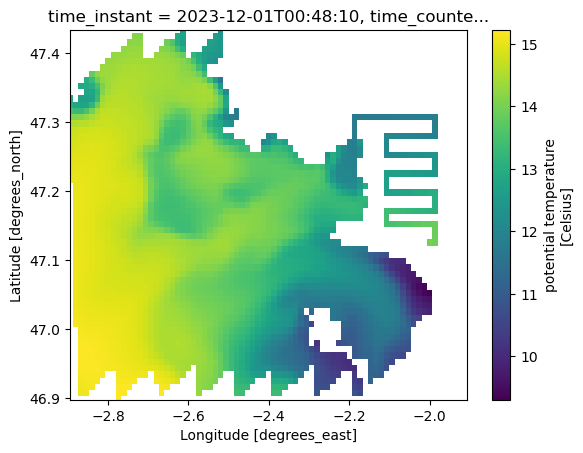

In [8]:
ds_temp.temp.isel(time_counter=0, s_rho=0).plot(
    y='nav_lat_rho', x='nav_lon_rho'
    ,  ylim=(lat_min, lat_max)
, xlim = (lon_min, lon_max)
)

## 5. **Write a temporary Zarr** (e.g. `small.zarr`) for use by `regrid_apply_ufunc.ipynb`

To make the next steps (regridding) fast and reproducible, we write the masked / subsetted dataset to a local Zarr store.

Tip: adjust `OUT_ZARR` to a location that exists on your machine (or to a shared scratch directory on HPC).


In [8]:
%%time
OUT_ZARR = "/Users/todaka/data/RIOMAR/small.zarr"
ds_temp.to_zarr(OUT_ZARR, mode="w")

/Users/todaka/micromamba/envs/pangeo/lib/python3.13/site-packages/zarr/api/asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 12.7 s, sys: 7.4 s, total: 20.1 s
Wall time: 1min 56s


**Re-open the Zarr subset and plot**

This verifies that the data were written correctly and can be opened independently of the original Kerchunk catalog.


CPU times: user 40.3 ms, sys: 8.61 ms, total: 48.9 ms
Wall time: 48.4 ms


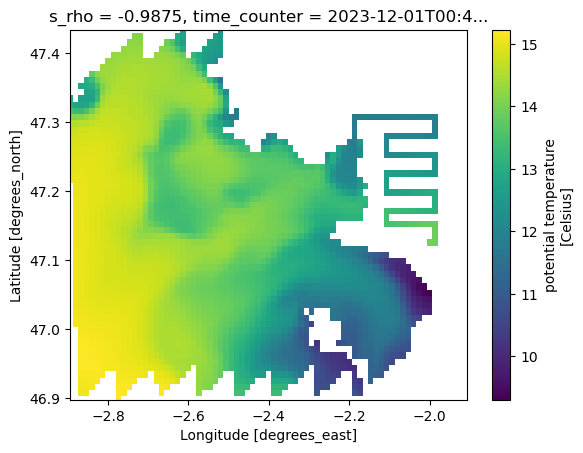

In [9]:
%%time
OUT_ZARR = "/Users/todaka/data/RIOMAR/small.zarr"

small_ds = xr.open_zarr(OUT_ZARR)

small_ds.temp.isel(time_counter=0, s_rho=0).plot(
    y="nav_lat_rho", x="nav_lon_rho",
    ylim=(lat_min, lat_max)
, xlim = (lon_min, lon_max)
)

**Optional: broader view**

A second plot with wider latitude limits can help spot any unexpected artifacts (e.g., missing values, wrap-around).


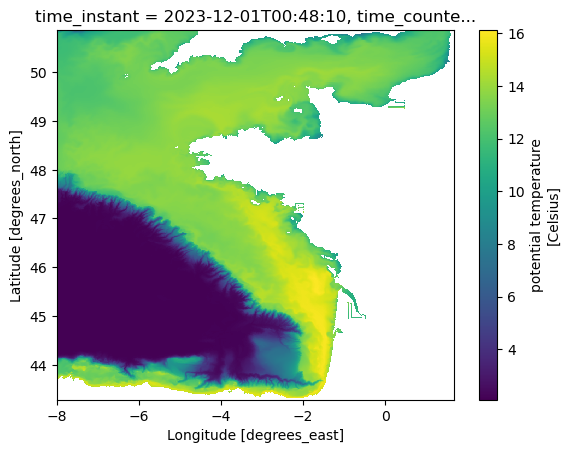

In [14]:
lat = ds["nav_lat_rho"]
lon = ds["nav_lon_rho"]

valid = (lat != -1) & (lon != -1)  # or (lat > -90) & (lon > -180) if you prefer

lat_min = lat.where(valid).min().item()
lat_max = lat.where(valid).max().item()
lon_min = lon.where(valid).min().item()
lon_max = lon.where(valid).max().item()

ds.temp.isel(time_counter=0, s_rho=0).plot(
    y="nav_lat_rho", x="nav_lon_rho",
    ylim=(lat_min, lat_max)
, xlim = (lon_min, lon_max)
)


**(Optional) Convert ROI data to an XDGGs / HEALPix-indexed DataArray**

If your next step is to move from the native model grid to a **DGGS** representation (e.g. HEALPix),
it can be convenient to store values against a `cell_ids` index.

The helper below builds an `xarray.DataArray` that follows the metadata conventions expected by `xdggs`.
You can then attach this to a dataset, write it to Zarr, or use it in downstream regridding/resampling code.


In [13]:
import numpy as np
import xarray as xr
import xdggs

def make_xdggs_dataarray_from_cell_ids(
    data,
    cell_ids,
    level: int = 15,
    name: str = "da",
):
    """
    Build an xdggs-compatible DataArray indexed by HEALPix `cell_ids`.

    Parameters
    ----------
    data : array-like
        Values for each cell (same length as `cell_ids`).
    cell_ids : array-like of int
        HEALPix cell identifiers (nested indexing).
    level : int
        HEALPix resolution level.
    name : str
        Name of the DataArray.

    Returns
    -------
    xr.DataArray
        Decoded and enriched with latitude/longitude coordinates via xdggs.
    """
    cell_ids = np.asarray(cell_ids, dtype=np.int64)

    da = xr.DataArray(
        data,
        dims=("cell_ids",),
        coords={"cell_ids": ("cell_ids", cell_ids)},
        name=name,
    )

    # Minimal metadata expected by xdggs
    da["cell_ids"].attrs.update(
        {
            "grid_name": "healpix",
            "level": int(level),
            "indexing_scheme": "nested",
            "ellipsoid": "WGS84",
        }
    )

    # Decode -> attach DGGS accessor -> compute lat/lon coordinates
    return da.pipe(xdggs.decode).dggs.assign_latlon_coords()


import numpy as np

with np.load("parent_ids.npz") as data:
    parent_ids = data["parent_ids"]
    parent_level = int(data["parent_level"])

da_hp = make_xdggs_dataarray_from_cell_ids(np.ones(len(parent_ids)), parent_ids, level=parent_level)
da_hp.dggs.explore(alpha=0.3)
